<a href="https://colab.research.google.com/github/AkindeKadjo/Reddit_classification_NLP/blob/main/Reddit_science.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

By Akinde Kadjo

**Goal**: The goal of this project is to predict from a set of conversation gavered from reddit whether the topics were Biology, Chemistry or Physics. The Dataset was obtained from [Kaggle](https://https://www.kaggle.com/datasets/vivmankar/physics-vs-chemistry-vs-biology/data).

# Import and Data Loading

In [ ]:
!pip install lazypredict

In [2]:
#Importing all of the libraries that may be needed for the project
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import string
import re
import nltk
from wordcloud import WordCloud
import itertools
from scipy.stats import f_oneway
from statsmodels.stats.multicomp import pairwise_tukeyhsd
from sklearn.feature_extraction.text import CountVectorizer

from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.compose import make_column_selector, make_column_transformer
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import Perceptron

from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from xgboost import XGBRegressor, XGBClassifier
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression, LinearRegression

from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, accuracy_score, precision_score, recall_score, balanced_accuracy_score
from sklearn.metrics import classification_report, ConfusionMatrixDisplay,roc_auc_score,PrecisionRecallDisplay, RocCurveDisplay,f1_score

from xgboost import XGBClassifier

import lazypredict
from lazypredict.Supervised import LazyClassifier


In [3]:
#Loading the data
train_file= '/content/drive/MyDrive/ML project/BioChemPhys/train.csv'
train_df = pd.read_csv(train_file)
original_df = train_df.copy()
print(f'train data shape: {train_df.shape}')
test_file= '/content/drive/MyDrive/ML project/BioChemPhys/test.csv'
test_df = pd.read_csv(test_file)
print(f'test data shape: {test_df.shape}')

train data shape: (8695, 3)
test data shape: (1586, 3)


# Functions

In order to keep a clean notebook, I'm storing all of the functions that I've created in this section.

In [4]:
#remove punctuation
def remove_punct(text):
    text_nopunct = "".join([char for char in text if char not in string.punctuation])
    return text_nopunct

In [5]:
#tokenization
def tokenize(text):
    tokens = re.split('\W+', text)
    return tokens

In [6]:
#remove stop words
nltk.download('stopwords')
stopword = nltk.corpus.stopwords.words('english')
#' '.join([word for word in re.findall(r'\b\w+\b', sample_string) if word not in stop_words])
def remove_stopwords(tokenized_list):
    text = [word for word in tokenized_list if word not in stopword]
    return text

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [7]:
#converging words with same root
nltk.download('wordnet')
wn = nltk.WordNetLemmatizer()
ps = nltk.PorterStemmer()
def lemmatizing(tokenized_text):
    text = [wn.lemmatize(word) for word in tokenized_text]
    return text
def stemming(tokenized_text):
    text = [ps.stem(word) for word in tokenized_text]
    return text

[nltk_data] Downloading package wordnet to /root/nltk_data...


In [8]:
#all at once
def clean_text(text):
    text = "".join([word for word in text if word not in string.punctuation])
    tokens = re.split('\W+', text)
    text = [word for word in tokens if word not in stopword]
    text = [wn.lemmatize(word) for word in text]
    return text

In [9]:
def Clouds(df):
  new = df['Comment'].tolist()
  new = list(itertools.chain(*new))
  word_freq = {}
  for word in new:
      if word in word_freq:
          word_freq[word] += 1
      else:
          word_freq[word] = 1

  # Generate the word cloud
  wordcloud = WordCloud(width=600, height=300, background_color='white').generate_from_frequencies(word_freq)

  # Plot the word cloud
  plt.figure(figsize=(9, 7))
  plt.imshow(wordcloud, interpolation='bilinear')
  plt.axis('off')
  plt.show()

In [10]:
def meaningful_df(dataframe, p_threshold):
    stat_list = []
    #splitting both classes
    Bio = dataframe.loc[dataframe['Topic'] == 'Biology']
    Chem = dataframe.loc[dataframe['Topic'] == 'Chemistry']
    Phys = dataframe.loc[dataframe['Topic'] == 'Physics']

    for col in list(dataframe.columns[:-1]):
        stat, p = f_oneway(Bio[col], Chem[col], Phys[col])
        if p > p_threshold:
            ak = 'they are statistically the same'
        else:
            stat_list.append(col)

    new_df = dataframe[stat_list]
    return new_df

In [11]:
#removing features highly correlated
def nocolinear_df(dataframe, threshold):
    corr = dataframe.corr().abs()
    upper = corr.where(np.triu(np.ones(corr.shape), k=1).astype(bool))
    to_drop = [column for column in upper.columns if any(upper[column] > threshold)]
    new_df = dataframe.drop(dataframe[to_drop], axis=1)
    return new_df

In [12]:
def CleanClouds(df,topic):
  new_df = pd.concat([df,train_df['Topic'] ], axis = 1)
  n_df = new_df.loc[new_df['Topic'] == topic]
  n_df = n_df.drop(columns='Topic')
  word_freq = n_df.sum().to_dict()

  # Generate the word cloud
  wordcloud = WordCloud(width=600, height=300, background_color='white').generate_from_frequencies(word_freq)

  # Plot the word cloud
  plt.figure(figsize=(9, 7))
  plt.imshow(wordcloud, interpolation='bilinear')
  plt.axis('off')
  plt.show()

In [13]:
#creating a data frame output of the metrics without confusion metrics
def res_reg(model,xtest,ytest,xtrain,ytrain):
    """Output regression metrics for both the test and the train data"""
    ## Get Predictions
    test_pred, train_pred = (model.predict(xtest)), (model.predict(xtrain))
    #test metrics
    mse_test = mean_squared_error(ytest, test_pred)
    rmse_test = np.sqrt(mse_test).round(4)
    r2_test = r2_score(ytest, test_pred).round(4)
    res_df_test = pd.DataFrame([rmse_test,r2_test], columns=['Test data'],index=['RMSE','R2'])
    #train metrics
    mse_train = mean_squared_error(ytrain, train_pred)
    rmse_train = np.sqrt(mse_train).round(4)
    r2_train = r2_score(ytrain, train_pred).round(4)
    res_df_train = pd.DataFrame([rmse_train,r2_train],columns=['Training data'],index=['RMSE','R2'])
    res_df = pd.concat([res_df_test, res_df_train],axis = 1)
    return res_df

In [14]:
def model_prediction(model):
    model = model
    scaler = StandardScaler()
    model_pipe = make_pipeline(scaler, model)
    model_pipe.fit(X_train, y_train)
    #Evaluating the model
    res = res_reg(model_pipe,X_test,y_test, X_train,y_train)
    return res

# Data Cleaning

In [15]:
train_df.head(3)

,Id,Comment,Topic
0,0x840,A few things. You might have negative- frequen...,Biology
1,0xbf0,Is it so hard to believe that there exist part...,Physics
2,0x1dfc,There are bees,Biology


In [16]:
#checking for duplicate
train_df.duplicated().sum()

0

In [17]:
#let's take a look at the second comment
train_df['Comment'][1]

"Is it so hard to believe that there exist particulars out that that we can't detect with anything we've invented so far.\\n\\nI mean look how long it took humans to find out a way to detect radiation."

In [18]:
#removing punctuation
print(f'The following punctuations will be removed: {string.punctuation}')
train_df['Comment'] = train_df['Comment'].apply(lambda x: remove_punct(x))
train_df.head(3)

The following punctuations will be removed: !"#$%&'()*+,-./:;<=>?@[\]^_`{|}~


,Id,Comment,Topic
0,0x840,A few things You might have negative frequency...,Biology
1,0xbf0,Is it so hard to believe that there exist part...,Physics
2,0x1dfc,There are bees,Biology


In [19]:
#tokenization
train_df['Comment'] = train_df['Comment'].apply(lambda x: tokenize(x.lower()))
train_df.head(3)

,Id,Comment,Topic
0,0x840,"[a, few, things, you, might, have, negative, f...",Biology
1,0xbf0,"[is, it, so, hard, to, believe, that, there, e...",Physics
2,0x1dfc,"[there, are, bees]",Biology


In [20]:
#removing stop words
print(f'few examples of stop words are: {stopword[0:5]}')
train_df['Comment'] = train_df['Comment'].apply(lambda x: remove_stopwords(x))
train_df.head(3)

few examples of stop words are: ['i', 'me', 'my', 'myself', 'we']


,Id,Comment,Topic
0,0x840,"[things, might, negative, frequency, dependent...",Biology
1,0xbf0,"[hard, believe, exist, particulars, cant, dete...",Physics
2,0x1dfc,[bees],Biology


In [21]:
train_df['Comment'] = train_df['Comment'].apply(lambda x: lemmatizing(x))
train_df['Comment'] = train_df['Comment'].apply(lambda x: stemming(x))
train_df.head(3)

,Id,Comment,Topic
0,0x840,"[thing, might, neg, frequenc, depend, select, ...",Biology
1,0xbf0,"[hard, believ, exist, particular, cant, detect...",Physics
2,0x1dfc,[bee],Biology


# Visualization

In [22]:
train_df['Topic'].value_counts(normalize=True)

Biology     0.41
Chemistry   0.34
Physics     0.25
Name: Topic, dtype: float64

In [23]:
#Splitting into each group
Bio_df = train_df.loc[train_df['Topic'] =='Biology']
Chem_df = train_df.loc[train_df['Topic'] =='Chemistry']
Phys_df = train_df.loc[train_df['Topic'] =='Physics']

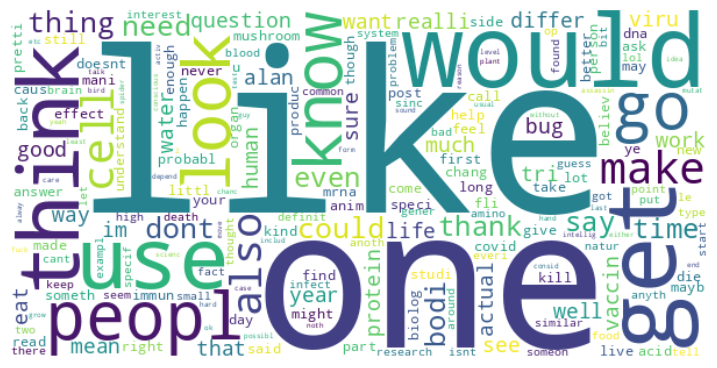

In [24]:
Clouds(Bio_df)

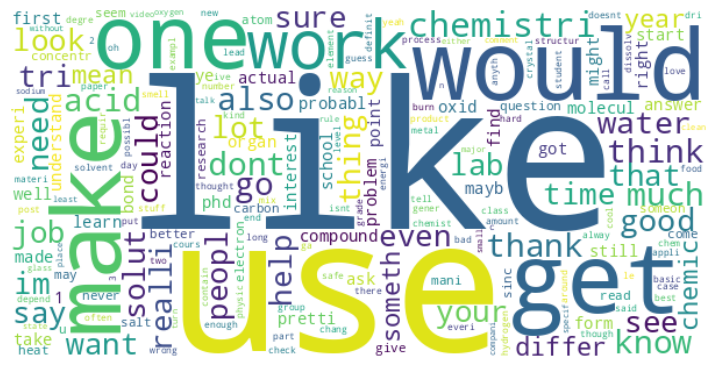

In [25]:
Clouds(Chem_df)

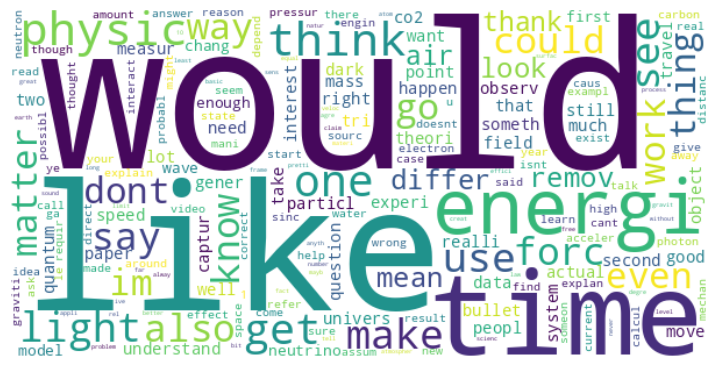

In [26]:
Clouds(Phys_df)

As seen from the world cloud, a lot of words like: "one, would,like" are seen in all 3 groups. So we'll need to remove the ones that are statistically equally present in all groups. This will be done after vectorization.

# Vectorization

In [27]:
count_vect = CountVectorizer(analyzer=clean_text)
X_counts = count_vect.fit_transform(original_df['Comment'])
print(X_counts.shape)
print(count_vect.get_feature_names_out())

(8695, 20850)
['' '0' '000' ... 'اکبر' 'ℝ' 'ー']


In [28]:
text = train_df['Comment'].map(' '.join)
count_vec = CountVectorizer()
X_counts = count_vec.fit_transform(text)
print(X_counts.shape)
print(count_vec.get_feature_names_out())

(8695, 14815)
['000' '000000000000000000000000332' '0000705' ... 'чернобыль' 'الله'
 'اکبر']


In [29]:
X_counts_df = pd.DataFrame(X_counts.toarray())
X_counts_df.columns = count_vec.get_feature_names_out()
X_counts_df.head(2)

,000,000000000000000000000000332,0000705,0001,0005,001,0012,002,002008,01,...,área,árvore,æther,μgg,μm,μμk,ψ2sk,чернобыль,الله,اکبر
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [30]:
df = pd.concat([X_counts_df,train_df['Topic'] ], axis = 1)
df.head(2)

,000,000000000000000000000000332,0000705,0001,0005,001,0012,002,002008,01,...,árvore,æther,μgg,μm,μμk,ψ2sk,чернобыль,الله,اکبر,Topic
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,Biology
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,Physics


# Feature Selection

In [31]:
df[['like', 'Topic']].groupby('Topic').mean()

,like
Topic,
Biology,0.14
Chemistry,0.13
Physics,0.12


In [32]:
# Perform one-way ANOVA
f_statistic, p_value = f_oneway(df[df['Topic'] == 'Biology']['like'],
                                 df[df['Topic'] == 'Chemistry']['like'],
                                 df[df['Topic'] == 'Physics']['like'])
print('One-way ANOVA p-value:', p_value)

One-way ANOVA p-value: 0.1664781024178589


In [33]:
f_statistic, p_value = f_oneway(df[df['Topic'] == 'Biology']['acet'],
                                 df[df['Topic'] == 'Chemistry']['acet'],
                                 df[df['Topic'] == 'Physics']['acet'])
print('One-way ANOVA p-value:', p_value)

One-way ANOVA p-value: 0.001446668417196081


In [34]:
tukey_results = pairwise_tukeyhsd(df['acet'], df['Topic'])
print('Tukey-adjusted p-values:')
print(tukey_results)

Tukey-adjusted p-values:
   Multiple Comparison of Means - Tukey HSD, FWER=0.05    
  group1    group2  meandiff p-adj   lower   upper  reject
----------------------------------------------------------
  Biology Chemistry   0.0053 0.0045  0.0014  0.0092   True
  Biology   Physics  -0.0006 0.9494 -0.0048  0.0037  False
Chemistry   Physics  -0.0058  0.006 -0.0103 -0.0014   True
----------------------------------------------------------


let's remove columns that are statistically the same for all 3 topics similar to "like"

In [35]:
print(f'Initial shape: {df.shape}')
p_df = meaningful_df(df, 0.05)
print(f'Shape after meaninfull column selection: {p_df.shape}')

Initial shape: (8695, 14816)
Shape after meaninfull column selection: (8695, 1465)


In [36]:
p_df.head(2)

,10,100,158,2d,3d,4d,ab,abdomen,abstract,ac,...,yellow,yield,youd,youll,young,younger,your,youtub,zeolit,zero
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [37]:
#Removing highly co-linear features
lean_df = nocolinear_df(p_df, 0.90)
print(f'Shape after co-linear removal: {lean_df.shape}')

Shape after co-linear removal: (8695, 1456)


In [38]:
df['target'] = df['Topic'].apply(lambda x: 0 if x =='Biology' else (1 if x == 'Chemistry' else 2))
df['target'].value_counts(normalize = True)

0   0.41
1   0.34
2   0.25
Name: target, dtype: float64

# Visualization after Cleaning

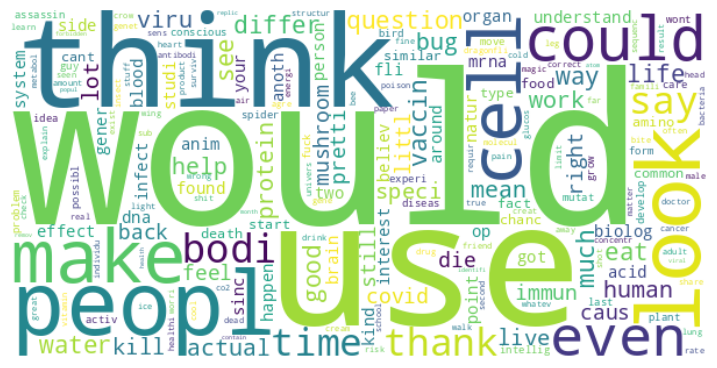

In [39]:
CleanClouds(lean_df,'Biology')

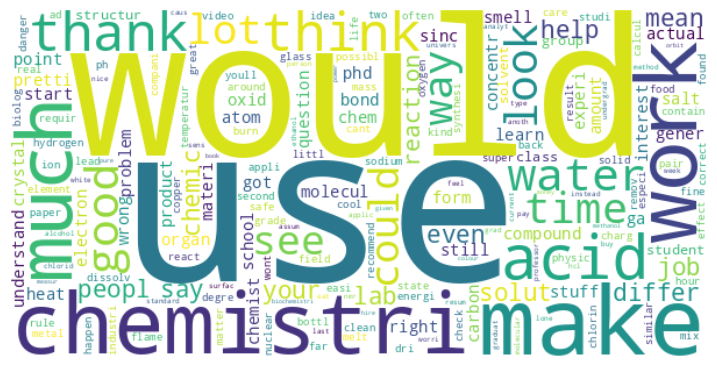

In [40]:
CleanClouds(lean_df,'Chemistry')

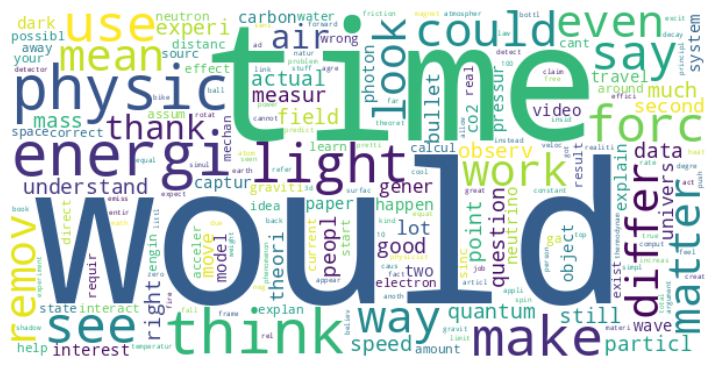

In [41]:
CleanClouds(lean_df,'Physics')

In [42]:
df[['would', 'Topic']].groupby('Topic').mean()

,would
Topic,
Biology,0.11
Chemistry,0.10
Physics,0.17


In [43]:
f_statistic, p_value = f_oneway(df[df['Topic'] == 'Biology']['would'],
                                 df[df['Topic'] == 'Chemistry']['would'],
                                 df[df['Topic'] == 'Physics']['would'])
print('One-way ANOVA p-value:', p_value)

One-way ANOVA p-value: 6.397666913415586e-07


In [44]:
tukey_results = pairwise_tukeyhsd(df['would'], df['Topic'])
print('Tukey-adjusted p-values:')
print(tukey_results)

Tukey-adjusted p-values:
   Multiple Comparison of Means - Tukey HSD, FWER=0.05   
  group1    group2  meandiff p-adj   lower  upper  reject
---------------------------------------------------------
  Biology Chemistry  -0.0021 0.9829 -0.0302 0.0259  False
  Biology   Physics   0.0625    0.0  0.0319  0.093   True
Chemistry   Physics   0.0646    0.0  0.0328 0.0965   True
---------------------------------------------------------


"Would" suprisingly finds itself in all 3 categories, but based on the small overall p-value the null hypothesis that all 3 of them are statistically the same is rejected.

# Models

In [45]:
#Data Splitting and Preprocessing
y = df['target']
X = lean_df
#Performing a train test split, here the random state of 42 is chosen for consistency
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 42,test_size = 0.20)

In [46]:
clf = LazyClassifier(verbose=0,ignore_warnings=True, custom_metric=None)
models,predictions = clf.fit(X_train, X_test, y_train, y_test)
models.head()

 97%|█████████▋| 28/29 [12:11<00:20, 20.14s/it]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.022428 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2404
[LightGBM] [Info] Number of data points in the train set: 6956, number of used features: 498
[LightGBM] [Info] Start training from score -0.886687
[LightGBM] [Info] Start training from score -1.093307
[LightGBM] [Info] Start training from score -1.374859


100%|██████████| 29/29 [12:13<00:00, 25.30s/it]


,Accuracy,Balanced Accuracy,ROC AUC,F1 Score,Time Taken
Model,,,,,
Perceptron,0.71,0.70,None,0.71,2.71
SGDClassifier,0.70,0.68,None,0.70,7.98
LogisticRegression,0.69,0.67,None,0.69,6.24
LinearSVC,0.69,0.67,None,0.69,80.32
ExtraTreesClassifier,0.69,0.66,None,0.68,24.89


In [52]:
model = Perceptron()
scaler = StandardScaler()
model_pipe = make_pipeline(scaler, model)
model_pipe.fit(X_train, y_train)
#Evaluating the model
test_pred = model_pipe.predict(X_test)
print(f'Balanced accuracy: {round((balanced_accuracy_score(y_test, test_pred)), 4)}')
res = res_reg(model_pipe,X_test,y_test, X_train,y_train)
res

Balanced accuracy: 0.6798


,Test data,Training data
RMSE,0.72,0.61
R2,0.18,0.42


# Test Data

In [48]:
test_df.head(3)

,Id,Comment,Topic
0,0x1aa9,Personally I have no idea what my IQ is. I’ve ...,Biology
1,0x25e,I'm skeptical. A heavier lid would be needed t...,Physics
2,0x1248,I think I have 100 cm of books on the subject....,Biology


In [49]:
#Cleaning
test_df['Comment'] = test_df['Comment'].apply(lambda x: remove_punct(x))
test_df['Comment'] = test_df['Comment'].apply(lambda x: tokenize(x.lower()))
test_df['Comment'] = test_df['Comment'].apply(lambda x: remove_stopwords(x))
test_df['Comment'] = test_df['Comment'].apply(lambda x: lemmatizing(x))
test_df['Comment'] = test_df['Comment'].apply(lambda x: stemming(x))
test_df.head(3)

,Id,Comment,Topic
0,0x1aa9,"[person, idea, iq, never, test, howev, test, o...",Biology
1,0x25e,"[im, skeptic, heavier, lid, would, need, build...",Physics
2,0x1248,"[think, 100, cm, book, subject, tldr, problem,...",Biology


In [53]:
text = test_df['Comment'].map(' '.join)
count_vec = CountVectorizer()
X_counts = count_vec.fit_transform(text)
print(X_counts.shape)
print(count_vec.get_feature_names_out())

(1586, 9238)
['000' '000063' '000063245553squareroot' ... 'γt' 'δx' 'δxvi']


In [54]:
X_counts_df = pd.DataFrame(X_counts.toarray())
X_counts_df.columns = count_vec.get_feature_names_out()
X_counts_df.head(2)

,000,000063,000063245553squareroot,0013,01,0102,016666667nnedit,0167,01g,03,...,zohaib,zona,zp,zurich,zwicki,µs,β99,γt,δx,δxvi
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [62]:
newtest_df= pd.DataFrame()
for col in list(lean_df.columns):
  if col in list(X_counts_df.columns):
    newtest_df[col] = X_counts_df[col]
  else:
    newtest_df[col] = pd.Series([0]*(len(X_counts_df)))
  #newtest_df= pd.concat([newtest_df,newtest_df[col]], axis = 1)

newtest_df.shape

(1586, 1456)

In [63]:
newtest_df.head(2)

,10,100,158,2d,3d,4d,ab,abdomen,abstract,ac,...,yellow,yield,youd,youll,young,younger,your,youtub,zeolit,zero
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [65]:
#Evaluating the model with the test dataset
test_pred = model_pipe.predict(newtest_df)
y_test = test_df['Topic'].apply(lambda x: 0 if x =='Biology' else (1 if x == 'Chemistry' else 2))
print(f'Balanced accuracy: {round((balanced_accuracy_score(y_test, test_pred)), 4)}')

Balanced accuracy: 0.7892


# Conclusion

Overall, I was able to achieve 78.92% accurracy with the test data set with the chosen model.